In [2]:
!pip install pyLDAvis 
!pip install spacy

In [3]:
# Importing packages
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
import nltk
import numpy as np
import spacy

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load #  for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz #  for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from PIL import Image

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')


# Natural Language Processing Toolkit
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
# from nltk.stem import PorterStemmer (I played around with Stemmer and decided to use Lemmatizer instead)
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from nltk import pos_tag # For Parts of Speech tagging

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nhgirma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nhgirma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nhgirma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/nhgirma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nhgirma/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
model_df = pd.read_csv('clean_processed_tweet_data.csv')
model_df = model_df.fillna("")
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,\n\nLets focus in one very specific zone of th...,-1,0.000000e+00,0.08125,en,15760,2,i_ameztoy,232,20497,2621,,City,,,
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,#China's media explains the military reasons ...,0,-1.000000e-01,0.10000,en,6967,201,ZIisq,3,65,272,,China,,,
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...","China even cut off communication, they don't a...",-1,0.000000e+00,0.00000,en,2166,0,Fin21Free,0,85,392,,XiJinping,,Netherlands,
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",1,1.000000e-01,0.35000,en,2166,0,Fin21Free,0,85,392,,XiJinping,,Netherlands,
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...","I’m sorry, I thought Taiwan was an independen...",0,-6.938894e-18,0.55625,en,17247,381,VizziniDolores,0,910,2608,,,,"Ayent, Schweiz",


In [5]:
model_df.shape

(22000, 20)

In [6]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              22000 non-null  object 
 1   statuses_count          22000 non-null  int64  
 2   source                  22000 non-null  object 
 3   original_text           22000 non-null  object 
 4   clean_text              22000 non-null  object 
 5   sentiment               22000 non-null  int64  
 6   polarity                22000 non-null  float64
 7   subjectivity            22000 non-null  float64
 8   lang                    22000 non-null  object 
 9   favorite_count          22000 non-null  int64  
 10  retweet_count           22000 non-null  int64  
 11  original_author         22000 non-null  object 
 12  screen_count            22000 non-null  int64  
 13  followers_count         22000 non-null  int64  
 14  friends_count           22000 non-null

In [7]:
# Check missing values

print("The number of missing value(s): {}".format(model_df.isnull().sum().sum()))
print("Columons having columns value:{}".format(model_df.columns[model_df.isnull().any()]))

The number of missing value(s): 0
Columons having columns value:Index([], dtype='object')


In [8]:
# Check for "NaN" values
model_df.isna().any() 

created_at                False
statuses_count            False
source                    False
original_text             False
clean_text                False
sentiment                 False
polarity                  False
subjectivity              False
lang                      False
favorite_count            False
retweet_count             False
original_author           False
screen_count              False
followers_count           False
friends_count             False
possibly_sensitive        False
hashtags                  False
user_mentions             False
place                     False
place_coord_boundaries    False
dtype: bool

In [9]:
def preprocessTweets(tweet):
    
    # Remove punctuations
    unpunctuated_words = [char for char in tweet_tokens if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words) 

In [10]:
# function to obtain adjectives from tweets

def getAdjectives(tweet):
    tweet = word_tokenize(tweet)  # convert string to tokens
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  # pos_tag module in NLTK library
    return " ".join(tweet)  

In [11]:
# get called 'Tweets_Adjectives'
model_df['Tweets_Adjectives'] = model_df['clean_text'].apply(getAdjectives)

In [12]:
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,\n\nLets focus in one very specific zone of th...,-1,0.000000e+00,0.08125,en,15760,...,i_ameztoy,232,20497,2621,,City,,,,specific western
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,#China's media explains the military reasons ...,0,-1.000000e-01,0.10000,en,6967,...,ZIisq,3,65,272,,China,,,,military
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...","China even cut off communication, they don't a...",-1,0.000000e+00,0.00000,en,2166,...,Fin21Free,0,85,392,,XiJinping,,Netherlands,,clown
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",1,1.000000e-01,0.35000,en,2166,...,Fin21Free,0,85,392,,XiJinping,,Netherlands,,vassal Ukrainian
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...","I’m sorry, I thought Taiwan was an independen...",0,-6.938894e-18,0.55625,en,17247,...,VizziniDolores,0,910,2608,,,,"Ayent, Schweiz",,m independent own military


In [13]:
def preprocessTweetsSentiments(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer() # initialize an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w) for w in tweet_tokens]
    return " ".join(lemma_words)

In [14]:
model_df['Tweets_Sentiments'] = model_df['clean_text'].apply(preprocessTweetsSentiments)

In [15]:
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives,Tweets_Sentiments
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,\n\nLets focus in one very specific zone of th...,-1,0.000000e+00,0.08125,en,15760,...,232,20497,2621,,City,,,,specific western,Lets focus in one very specific zone of the we...
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,#China's media explains the military reasons ...,0,-1.000000e-01,0.10000,en,6967,...,3,65,272,,China,,,,military,# China 's medium explains the military reason...
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...","China even cut off communication, they don't a...",-1,0.000000e+00,0.00000,en,2166,...,0,85,392,,XiJinping,,Netherlands,,clown,"China even cut off communication , they do n't..."
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",1,1.000000e-01,0.35000,en,2166,...,0,85,392,,XiJinping,,Netherlands,,vassal Ukrainian,"Putin to # XiJinping : I told you my friend , ..."
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...","I’m sorry, I thought Taiwan was an independen...",0,-6.938894e-18,0.55625,en,17247,...,0,910,2608,,,,"Ayent, Schweiz",,m independent own military,"I ’ m sorry , I thought Taiwan wa an independe..."


In [16]:
# Extract all tweets into one long string with each word separate with a "space"
tweets_long_string = model_df['Tweets_Adjectives'].tolist()
tweets_long_string = " ".join(tweets_long_string)

In [17]:
# Function to create blue color for twitter logo
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

In [18]:
# Import Twitter Logo
image = np.array(Image.open('twitter_logo.png'))

In [19]:
from wordcloud import STOPWORDS,WordCloud
import random

(-0.5, 794.5, 788.5, -0.5)

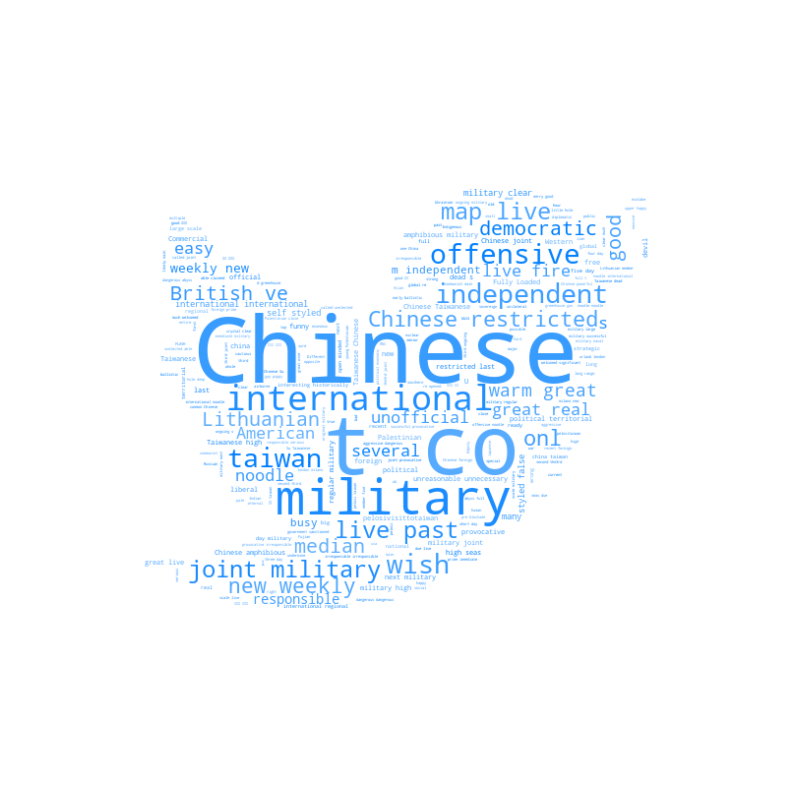

In [20]:
# Instantiate the Twitter word cloud object
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

# generate the word cloud
twitter_wc.generate(tweets_long_string)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')

In [21]:
# import textblob
from textblob import TextBlob

In [22]:
# Create function to obtain Subjectivity Score
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# Create function to obtain Polarity Score
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Create function to obtain Sentiment category
def getSentimentTextBlob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [23]:
# Apply all functions above to respective columns
# also used validate the dataset sentimnt values
model_df['Subjectivity'] = model_df['Tweets_Sentiments'].apply(getSubjectivity)
model_df['Polarity'] = model_df['Tweets_Sentiments'].apply(getPolarity)
model_df['Sentiment'] = model_df['Polarity'].apply(getSentimentTextBlob)

In [24]:
model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives,Tweets_Sentiments,Subjectivity,Polarity,Sentiment
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,\n\nLets focus in one very specific zone of th...,-1,0.000000e+00,0.08125,en,15760,...,,City,,,,specific western,Lets focus in one very specific zone of the we...,0.08125,0.000000e+00,Neutral
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,#China's media explains the military reasons ...,0,-1.000000e-01,0.10000,en,6967,...,,China,,,,military,# China 's medium explains the military reason...,0.10000,-1.000000e-01,Negative
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...","China even cut off communication, they don't a...",-1,0.000000e+00,0.00000,en,2166,...,,XiJinping,,Netherlands,,clown,"China even cut off communication , they do n't...",0.00000,0.000000e+00,Neutral
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",1,1.000000e-01,0.35000,en,2166,...,,XiJinping,,Netherlands,,vassal Ukrainian,"Putin to # XiJinping : I told you my friend , ...",0.35000,1.000000e-01,Positive
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...","I’m sorry, I thought Taiwan was an independen...",0,-6.938894e-18,0.55625,en,17247,...,,,,"Ayent, Schweiz",,m independent own military,"I ’ m sorry , I thought Taiwan wa an independe...",0.55625,-6.938894e-18,Negative


In [25]:
model_df['Sentiment'].value_counts()

Neutral     9257
Positive    7917
Negative    4826
Name: Sentiment, dtype: int64

In [26]:
import seaborn as sns

In [27]:
bar_plot =  model_df['Sentiment'].value_counts().rename_axis('Sentiment').to_frame('Total Tweets').reset_index()   


In [28]:
bar_plot

,Sentiment,Total Tweets
0,Neutral,9257
1,Positive,7917
2,Negative,4826


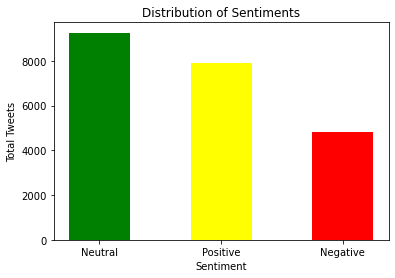

In [29]:
x = bar_plot['Sentiment']
y = bar_plot['Total Tweets']
c = ["green", "yellow", "red"]
plt.bar(x, y, width=0.5, color=c)
plt.xlabel("Sentiment")
plt.ylabel("Total Tweets")
plt.title("Distribution of Sentiments")
plt.show()

In [30]:
#model_df['Polarity'] = model_df['Polarity'].round(3)

In [31]:
sentiment_tweet = model_df[['Tweets_Sentiments','polarity']]

In [32]:
score = pd.Series([getSentimentTextBlob(row_value) for row_value in sentiment_tweet['polarity']])


In [33]:
sentiment_tweet = pd.concat([sentiment_tweet, score.rename("score")], axis=1)

In [34]:
sentiment_tweet.head()

,Tweets_Sentiments,polarity,score
0,Lets focus in one very specific zone of the we...,0.000000e+00,Neutral
1,# China 's medium explains the military reason...,-1.000000e-01,Negative
2,"China even cut off communication , they do n't...",0.000000e+00,Neutral
3,"Putin to # XiJinping : I told you my friend , ...",1.000000e-01,Positive
4,"I ’ m sorry , I thought Taiwan wa an independe...",-6.938894e-18,Negative


In [35]:
scoremap = pd.Series([1 if row_value == 'Positive' else 0 for row_value in sentiment_tweet['score']])

In [36]:
len(scoremap)

22000

In [37]:
sentiment_tweet['scoremap'] = scoremap
X = sentiment_tweet['Tweets_Sentiments']
y = sentiment_tweet['scoremap']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print(X_train.size,',' , X_test.size)
print(X_test.size, ',',y_test.size)

17600 , 4400
4400 , 4400


In [40]:
# scaling the input
clf = LinearSVC()

In [41]:
unigram_tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1, 1))
bigram_tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (2, 2))
hybrid_tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1, 2))

In [42]:
X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = unigram_tfidf_vectorizer.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
clf.fit(X_train_counts, y_train)

LinearSVC()

In [43]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = unigram_tfidf_vectorizer.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)


In [44]:
np.mean(prediction == y_test)

0.9643181818181819

In [45]:
X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = bigram_tfidf_vectorizer.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
clf.fit(X_train_counts, y_train)

LinearSVC()

In [46]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = bigram_tfidf_vectorizer.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)

In [47]:
np.mean(prediction == y_test)

0.9222727272727272

In [48]:
# X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = hybrid_tfidf_vectorizer.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
model = clf.fit(X_train_counts, y_train)

In [49]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = hybrid_tfidf_vectorizer.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)

In [50]:
np.mean(prediction == y_test)

0.9595454545454546

In [51]:
import pickle

In [52]:
pickle.dump(model, open('trained_model/model.pkl', 'wb'))

# Using PyLDAvis

In [53]:
from nltk.stem import PorterStemmer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords

In [54]:
def clean_text_cleaner(clean_text: str) -> str:
    cleaned_text = re.sub('\n', '', clean_text)
    cleaned_text = re.findall(r'[a-zA-Z]+', cleaned_text)
    cleaned_text = " ".join(cleaned_text)
    cleaned_text = re.sub(r'http.*', "", cleaned_text)

    return cleaned_text

In [55]:
model_df['clean_text'] = model_df['clean_text'].apply(clean_text_cleaner)

In [56]:
model_df['clean_text']

0        Lets focus in one very specific zone of the we...
1        China s media explains the military reasons fo...
2        China even cut off communication they don t an...
3        Putin to XiJinping I told you my friend Taiwan...
4        I m sorry I thought Taiwan was an independent ...
                               ...                        
21995    A good infographic of China s missile launches...
21996    A good infographic of China s missile launches...
21997                     Reuters Thanks Pelosi smart move
21998    Taiwan people s Desire for Unification With Ch...
21999    Taiwan people s Desire for Unification With Ch...
Name: clean_text, Length: 22000, dtype: object

In [57]:
# Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [58]:
topic_model_df = model_df.copy(deep=True)
topic_model_df.head()

,created_at,statuses_count,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,Tweets_Adjectives,Tweets_Sentiments,Subjectivity,Polarity,Sentiment
0,2022-08-07 22:31:20+00:00,8097,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,Lets focus in one very specific zone of the we...,-1,0.000000e+00,0.08125,en,15760,...,,City,,,,specific western,Lets focus in one very specific zone of the we...,0.08125,0.000000e+00,Neutral
1,2022-08-07 22:31:16+00:00,5831,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,China s media explains the military reasons fo...,0,-1.000000e-01,0.10000,en,6967,...,,China,,,,military,# China 's medium explains the military reason...,0.10000,-1.000000e-01,Negative
2,2022-08-07 22:31:07+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",China even cut off communication they don t an...,-1,0.000000e+00,0.00000,en,2166,...,,XiJinping,,Netherlands,,clown,"China even cut off communication , they do n't...",0.00000,0.000000e+00,Neutral
3,2022-08-07 22:31:06+00:00,1627,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",Putin to XiJinping I told you my friend Taiwan...,1,1.000000e-01,0.35000,en,2166,...,,XiJinping,,Netherlands,,vassal Ukrainian,"Putin to # XiJinping : I told you my friend , ...",0.35000,1.000000e-01,Positive
4,2022-08-07 22:31:04+00:00,18958,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",I m sorry I thought Taiwan was an independent ...,0,-6.938894e-18,0.55625,en,17247,...,,,,"Ayent, Schweiz",,m independent own military,"I ’ m sorry , I thought Taiwan wa an independe...",0.55625,-6.938894e-18,Negative


In [59]:
def get_hastags_words_list():
    hashtagList = []
    for hashtags in topic_model_df.hashtags:
        if(hashtags != ""):
            hashtagList += hashtags.split(',')

    return hashtagList

hashtag = get_hastags_words_list()

data = [word for sentence in topic_model_df.clean_text for word in sentence.split(' ')]

In [60]:
hashtag[:5]

['City', 'China', 'XiJinping', 'XiJinping', 'Taiwan']

In [61]:
data[:10]

['Lets',
 'focus',
 'in',
 'one',
 'very',
 'specific',
 'zone',
 'of',
 'the',
 'western']

In [62]:
data_words = data + hashtag
data_words = [word for word in data_words if word != '']
data_words[:5]

['Lets', 'focus', 'in', 'one', 'very']

In [63]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['L', 'e', 't', 's']


In [64]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [65]:
!python3 -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 12.8 MB 158 kB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

In [ ]:
data_lemmatized = [word for word in data_lemmatized if word != []]
data_lemmatized[:5]

In [ ]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus)

In [ ]:
# Readable View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Compute Perplexity
perplexity_score = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity_score)  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Compute Perplexity
perplexity_score = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity_score)  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
class PrepareData:
      def __init__(self,df):
        self.df=df
    
      def preprocess_data(self):
        tweets_df = self.df.loc[self.df['lang'] =="en"]

    
    #text Preprocessing
        model_df['clean_text']=model_df['clean_text'].astype(str)
        model_df['clean_text'] = model_df['clean_text'].str.replace('[^\w\s]\n','')
        model_df['clean_text'] = model_df['clean_text'].apply(lambda x: x.lower())
        model_df['clean_text']= model_df['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
        model_df['clean_text'] = model_df['clean_text'].str.replace('\w*\d\w*\n','')
        
        #stemmer = PorterStemmer()
        #model_df['clean_text'] = model_df['clean_text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))


        
      
        #model_df['clean_text'] = model_df['clean_text']

        #Converting tweets to list of words For feature engineering
        sentence_list = [tweet for tweet in model_df['clean_text']]
        word_list = [sent.split() for sent in sentence_list]
        # print(word_list)

        #Create dictionary which contains Id and word 
        word_to_id = corpora.Dictionary(word_list) #generate unique tokens
        #  we can see the word to unique integer mapping
        # print(word_to_id.token2id)
        # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
        corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]
        

        return word_list, word_to_id, corpus_1


In [ ]:
PrepareData_obj=PrepareData(model_df)
word_list ,id2word,corpus=PrepareData_obj.preprocess_data()

In [ ]:
model_df['clean_text'][0:5]

In [ ]:
print(corpus[0:3])

In [ ]:
id_words = [[(id2word[id], count) for id, count in line] for line in corpus]

In [ ]:
print(id_words[0:3])

In [ ]:
type(id_words)

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())

In [ ]:
pprint(lda_model.show_topics(formatted=False))

In [ ]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared